# [Daily Dose of Data Science](http://join.dailydoseofds.com/)

Code accompaning the newsletter issue: [Implementing a Siamese Network](https://blog.dailydoseofds.com/p/implementing-a-siamese-network)

Author: Avi Chawla

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torch import optim

## Dataset

In [22]:
class SiameseDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data    
        self.transform = transform
            
    def __getitem__(self, index):
        imgA, labelA = self.data[index]
        
        same_class_flag = random.randint(0, 1)
        
        if same_class_flag:
            labelB = -1
            
            while labelB != labelA:
                imgB, labelB = random.choice(self.data)
                
        else:
            labelB = labelA
            
            while labelB == labelA:
                imgB, labelB = random.choice(self.data)

        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)
            
        return imgA, imgB, torch.tensor([(labelA != labelB)], dtype=torch.float32)

    def __len__(self):
        return len(self.data)

In [24]:
mnist_train = MNIST(root='./data', train=True, download=True)
mnist_test = MNIST(root='./data', train=False, download=True)

transform = transforms.Compose([transforms.ToTensor()])

siamese_train = SiameseDataset(mnist_train, transform)
siamese_test = SiameseDataset(mnist_test, transform)

## Network

In [25]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 2)
        )

    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, inputA, inputB):
        outputA = self.forward_once(inputA)
        outputB = self.forward_once(inputB)
        return outputA, outputB

## Loss function

In [31]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, outputA, outputB, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

        same_class_loss = (1-label) * (euclidean_distance**2)
        diff_class_loss = (label) * (torch.clamp(self.margin - euclidean_distance, min=0.0)**2)
    
        return torch.mean(same_class_loss + diff_class_loss)

## Training

In [33]:
train_dataloader = DataLoader(siamese_train,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001 )

In [34]:
for epoch in range(5):
    total_loss = 0
    
    for imgA, imgB, label in train_dataloader:

        imgA, imgB, label = imgA.cuda(), imgB.cuda(), label.cuda()
        optimizer.zero_grad()
        outputA, outputB = net(imgA, imgB)
        loss_contrastive = criterion(outputA, outputB, label)
        loss_contrastive.backward()

        total_loss += loss_contrastive.item()
        optimizer.step()

    print(f"Epoch {epoch}; Loss {total_loss}")

Epoch 0; Loss 294.2397748604417
Epoch 1; Loss 102.84626789577305
Epoch 2; Loss 63.36508319573477
Epoch 3; Loss 44.61645963555202
Epoch 4; Loss 32.77574067004025


## Plot outputs

0.9199


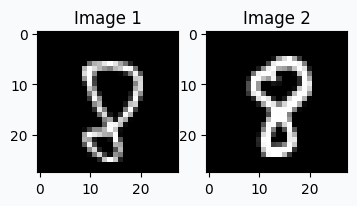

0.0439


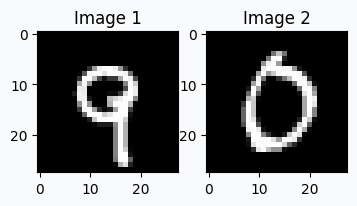

0.9008


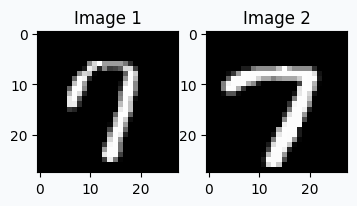

0.0399


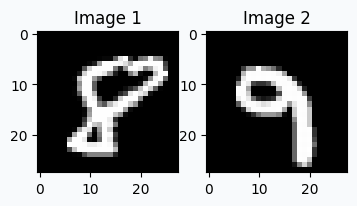

In [41]:
test_dataloader = DataLoader(siamese_test, shuffle=True, num_workers=8, batch_size=1)

def show_image_pair(imgA, imgB, label, similarity_score, i):
    
    fig, ax = plt.subplots(1, 2, figsize=(4, 4))
    ax[0].imshow(imgA.squeeze(), cmap='gray')
    ax[0].set_title('Image 1')
    ax[1].imshow(imgB.squeeze(), cmap='gray')
    ax[1].set_title('Image 2')
    plt.savefig(f"image_{i}.jpeg", bbox_inches="tight", dpi = 300)
    print(similarity_score)
    plt.show()

def visualize_siamese_pairs(data_loader, total_images=4):
    for idx, batch in enumerate(data_loader):

        if idx == total_images:
            return
            
        imgA, imgB, label = batch
        outputA, outputB = net(imgA.cuda(), imgB.cuda())
        euclidean_distance = F.pairwise_distance(outputA, outputB)
        similarity_score = torch.exp(-euclidean_distance)
        
        imgA = imgA[0].numpy()
        imgB = imgB[0].numpy()
        label = label[0].item()
        
        show_image_pair(imgA, imgB, label, round(similarity_score.item(), 4), idx)
        
visualize_siamese_pairs(test_dataloader, total_images=4)
